## Problema 2:
Considere el entramado mostrado en la figura, con una fuerza aplicada de 20 kN. Calcule los
desplazamientos de cada uno de los nodos y las tensiones que sufre cada elemento. Todos los
elementos tienen E = 210 GPa y una sección de 10 cm2, excepto el elemento 3, que tiene una
sección de 20 cm2. Los elementos 2 y 5 tienen una longitud de 8 metros y el elemento 3 de 4
metros.
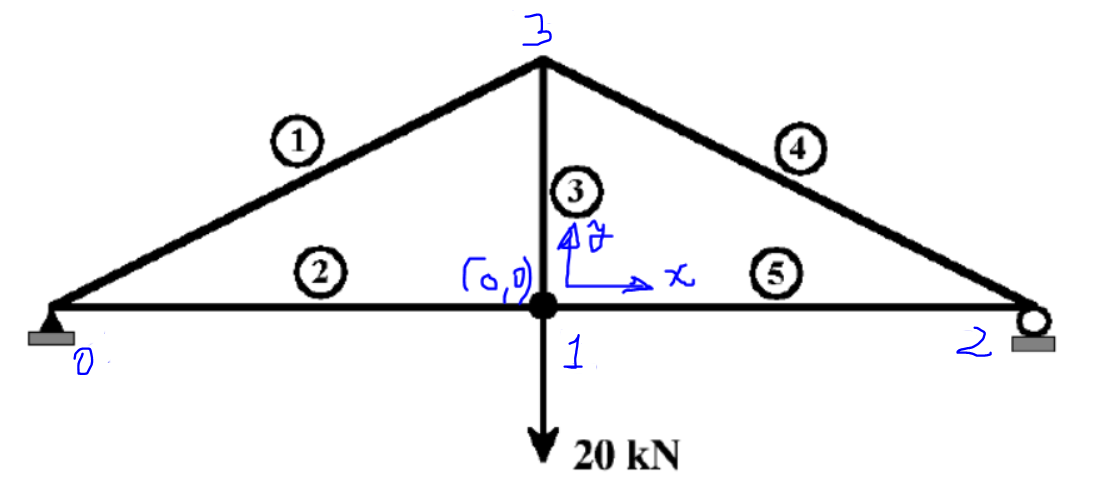
$$Ejemplo$$
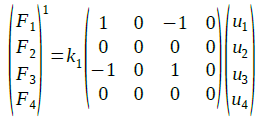
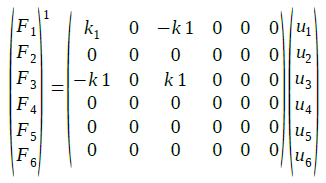

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy

#Modulo para leer los datos de un archivo
    #Condiciones de contorno, matriz de nodos y de conectividad
def leer_datos(nombre_archivo):
    nodos = []
    conect = []
    condc = []
    f = open(nombre_archivo, encoding='UTF-8')
    filas = csv.reader(f)
    for fila in filas:
        fila = fila[0].strip(';').split(';')         #Limpia la fila
        if not fila or fila[0] == '':
            continue
        if fila[0] in 'nodos, conectividad, condcont':
            header = copy.copy(fila)
            print(header)
            continue
        if header == 'nodos':
            nodos.append(fila) 
        conect = []
        condc = []
        
        print(fila)
        #print(nodos)
        #print(fila[0].strip(';').split(';'))

leer_datos('datos_puente.csv')
    
    
    

['nodos']
['-8', '0']
['0', '0']
['8', '0']
['0', '4']
['conectividad']
['0', '3']
['0', '1']
['1', '3']
['2', '3']
['1', '2']
['condcont']
['0', '-1']
['0', '-1']
['-1', '0']
['-1', '-20000']
['0', '-1']
['0', '-1']
['-1', '0']
['-1', '-20000']
['#u']


In [50]:
nodos

NameError: name 'nodos' is not defined

In [3]:

#Los datos luego deberian ser leidos de un archivo
#np.savetext('nombre_archivo.dat', dato, fmt='%8.3f')
#dato = np.loadtext('nombre_archivo.dat')

#Datos del problema

Fa = 20          #[kN] Fuerza externa aplicada
F_e = []         #Vector de fuerzas
u_e = []         #Vector de desplazamientos
E = 210*10**9   #[Pa]

A = [10, 10, 20, 10, 10]      
A_e = 1e-4*np.array(A)        #[m**2] secciones de cada elemento

MN = np.array([[-8, 0],                       #Matriz de nodos, cada fila es un nodo (x,y)
               [0, 0],
               [8, 0],
               [0, 4]]
             )     

MC = np.array([[0, 3],               #Matriz de conectividad de elementos, cada fila es un elemento con los nodos que lo componen
              [0, 1], 
              [1, 3], 
              [2, 3], 
              [1, 2]
              ])            #Si nombro a cada elemento primero con el nodo mas chico y luego el mas grande --> armo MK mejor

glxn = 2                             #Grados de libertad por nodo
n_nodos = len(MN[:,])                #Cantidad de nodos del sistema
gltot = n_nodos*glxn                 #Grados de libertad totales: 8
                                     #[nodo 0: (0,1)   nodo 1: (2,3)   nodo 2: (4,5)   nodo 3: (6,7)]
n_elem = len(MC[:,])

F = np.zeros((8,1))     #Fuerzas en cada nodo [0x, 0y, 1x, 1y, 2x, 2y,...]
U = np.zeros((8,1))     #Desplazamientos


def cs(ang):
    sc = np.sin(ang)*np.cos(ang)
    return round(sc, 8)

def c2(ang):
    c = np.cos(ang)*np.cos(ang)
    return round(c, 8)

def s2(ang):
    s = np.sin(ang)*np.sin(ang)
    return round(s, 8)


El ángulo de cada elemento quedará definido como el arcotangente del cociente entre la diferencia entre las coordenadas x y la diferencia entre las coordenadas y de los nodos que lo conforman
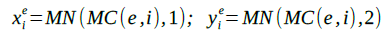
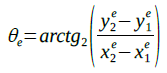

In [4]:
#Angulos de cada elemento
ang_e = []                          #Angulo de cada elemento
L_e = []                            #Largo de cada elemento
k_e = []                            #Cargo los k de cada elemento   k = EA/L
for e in range(len(MC[:,0])):       #Recorro todos los elementos desde 0 a 4
    x0 = MN[MC[e,0], 0]
    x1 = MN[MC[e,1], 0]
    y0 = MN[MC[e,0], 1]
    y1 = MN[MC[e,1], 1]
    
    ang = np.arctan2((y1-y0),(x1-x0))        #*180/np.pi
    ang_e.append(ang)
    
    L = np.sqrt((x1-x0)**2 + (y1-y0)**2)
    L_e.append(L)
    
    k = (E*A_e[e])/L
    k_e.append(k)

    

#Matriz de rigidez parcial:
Mk_e=[]                               #Lista con las matrices parciales de cada elemento
for e in range(len(MC[:,0])):
    ang = ang_e[e]
    ke = k_e[e]
    M_k = ke*np.array([[c2(ang), cs(ang), -c2(ang), -cs(ang)],                #Matriz de cada elemento con la rotacion
                      [cs(ang), s2(ang), -cs(ang), -s2(ang)],
                      [-c2(ang), -cs(ang), c2(ang), cs(ang)],
                      [-cs(ang), -s2(ang), cs(ang), s2(ang)]
                     ])
    Mk_e.append(M_k)

    
#Matriz de rigidez global:
MK = np.zeros([n_nodos*glxn, n_nodos*glxn])
for i, n in enumerate(MC, start=0):      #Las filas dan la cantidad de elementos
    
    #Guardo los nodos ni, nj que conforman al elemento i
    ni = n[0]
    nj = n[1]
    
    #Coordenadas para matriz local: indices de los grados de libertad
    #xl = 
    #yl = 
    
    #Coordenadas para matriz global
    xg = np.arange(ni*glxn,(ni+1)*glxn)
    yg = np.arange(nj*glxn,(nj+1)*glxn)
    #print(xi, yi)
    #print(n)
    
    #Aca uso numpy.ix_(xi, yi): cargo los 4 bloques de cada matriz local a la matriz global
    MK[np.ix_(xg, yg)] += Mk_e[i][np.ix_([0, 1], [2, 3])]     #[2*i, 2*i+1]  [2*j, 2*j+1]
    MK[np.ix_(yg, xg)] += Mk_e[i][np.ix_([2, 3], [0, 1])]
    MK[np.ix_(xg, xg)] += Mk_e[i][np.ix_([0, 1], [0, 1])]
    MK[np.ix_(yg, yg)] += Mk_e[i][np.ix_([2, 3], [2, 3])]
    
    

In [86]:
F_e = np.array([0, 0, 0, -20e3, 0, 0, 0, -20e3])
u_e = np.array([0, 0, 0, 0, 0, 0, 0, 0])

# Condiciones de contorno: u0=u1=u4=u5=0; F3=F7=-20; F2=F6=0
# M*u=F  --> entonces dejo a la izquierda del igual solo los grados de libertad que son incognia u2,u3,u6,u7
# Selecciono las filas corresp. a los grados de libertad incognita en la matriz global (filas 2, 3, 6, 7) (fuerzas conocidas)  
# y columnas los grados de libertad cuyos ui conozco (columna 0, 1, 4, 5)


r = [2, 3, 6, 7]         #Grados de libertad incognita  
s = [0, 1, 4, 5]         #Grados de libertad conocidos

#M_red = copy.copy(MK)
F_red = np.array([F_e[i] for i in r]).reshape(-1,1)
u_red = np.array([u_e[i] for i in s]).reshape(-1,1)

#Matriz coeficiente de vinculos
M_vin = MK[np.ix_(r, r)]

#Matriz reducida
M_red = MK[np.ix_(s, r)]      #mismo (r) porque son las mismas filas pero otros grados de libertas (s)
u_inc = np.linalg.solve(M_vin, F_red - np.dot(M_red, u_red))    #ur = Kr[F-Ks*us]

#Calculo las fuerzas restantes
F_inc = np.dot(MK[np.ix_(s, r)], u_inc)


#Los convierto en lista para trabajar mas facil
u_e = u_e.tolist()
F_e = F_e.reshape(-1,1)
F_e = F_e.tolist()


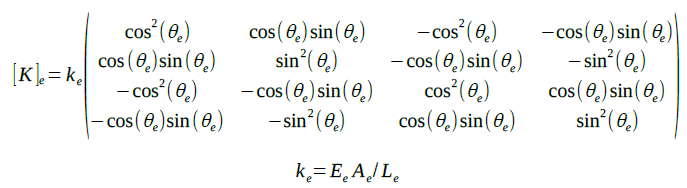
La matriz de rigidez de cada elemento va a ser de dimensiones: nº de nodos p/elemento X grados de libertad.
En este caso: 2 nodos x 2 dof  --> 4x4
La matriz grande general sera de dimensiones: 4 nodos X 2 dof  --> matriz de 8x8

### numpy.ix_(*args)

Using ix_ one can quickly construct index arrays that will index the cross product. a[np.ix_([1,3],[2,5])] returns the array [[a[1,2] a[1,5]], [a[3,2] a[3,5]]].

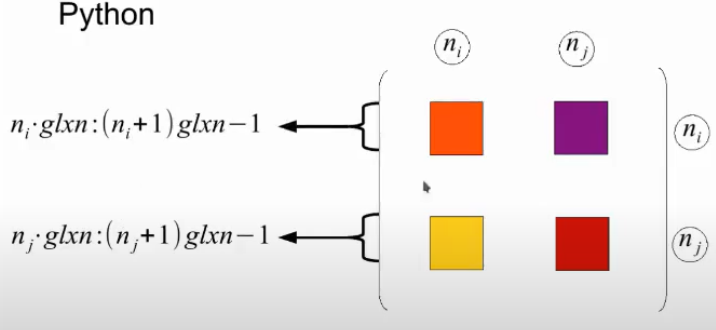


In [89]:
#Vectores finales de fuerzas y desplazamientos en cada nodo y cada grado de libertad
#u_e = u_e.reshape(1,-1)
#F_e = F_e.reshape(1,-1)

for i, f in enumerate(s, start=0):
    Fx = F_inc[i][0]
    F_e[f] = Fx
    
for i, u in enumerate(r, start=0):
    ux = u_inc[i][0]
    u_e[u] = ux
    #print(ue)




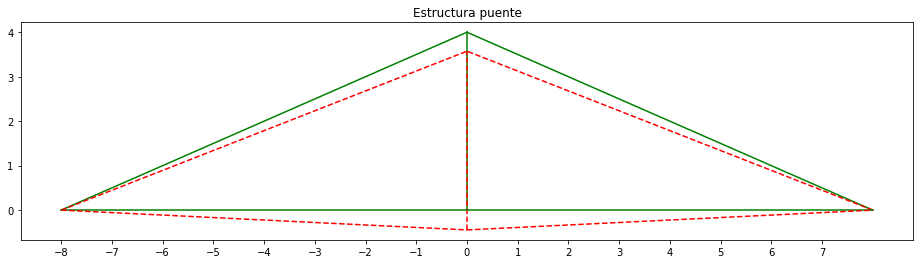

In [117]:
#Grafico de los resultados
plt.figure(figsize=(16,4))
for i, e in enumerate(MC):
    
    x = [MN[e[0]][0], MN[e[1]][0]]
    y = [MN[e[0]][1], MN[e[1]][1]]
    
    x_ = [MN[e[0]][0] + 100*ue_[e[0]][0] , MN[e[1]][0] + 100*ue_[e[1]][0]]
    y_ = [MN[e[0]][1] + 100*ue_[e[0]][1] , MN[e[1]][1] + 100*ue_[e[1]][1]]
    
    #print(x, y)
    plt.plot(x, y, 'g')
    plt.plot(x_, y_, 'r',linestyle='dashed')
    
    plt.title('Estructura puente')
    plt.xticks(np.arange(-8, 8, step=1))
    #plt.xlim(-9,9,1)
    #plt.ylim(0,5,1)




In [105]:
ue_
F_e

[39999.999999999956,
 19999.999999999978,
 [0.0],
 [-20000.0],
 -39999.999999999956,
 19999.999999999978,
 [0.0],
 [-20000.0]]